https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/
http://cxhernandez.com/tutorials/dataviz/2014/11/19/jointplot-d3.html

In [207]:
from astropy.io import fits
from astropy.io import ascii
from astropy import constants as c
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
from astroquery.sdss import SDSS

In [3]:
# define defaults for plotting

plt.rcParams.update({'font.size': 14})


two columns
- matched
- not matched
- use stellar masses as calculated from a100






## Definition of Functions ##

In [4]:
def colormag(mag, color, ab, ylabel):
    #plt.plot(mag, color,  'k.', alpha=.05)
    limits = [-23.9, -14.1, -.5, 1.9]
    flag = ab > 0.8
    #plt.hexbin(mag[flag],color[flag], extent=limits, cmap='gray_r', vmin=0,vmax=45)
    plt.plot(mag[flag],color[flag],'k.',alpha=.2, markersize=3, label='$B/A > 0.8$')
    flag = ab < 0.3
    #plt.hexbin(mag[flag],color[flag], extent=limits, cmap='Purples_r', vmin=0,vmax=45)
    plt.plot(mag[flag],color[flag],'c.',alpha=.2,markersize=3,label='$B/A < 0.3$')
    plt.axis(limits)
    plt.xticks(np.arange(-23,-14,2))
    plt.gca().invert_xaxis()
    plt.title(ylabel, fontsize=14)

In [5]:
def colormass(x1,y1,x2,y2,name1,name2, figname, hexbinflag=False,contourflag=False,
             xmin=7.9, xmax=11.6, ymin=-0.05, ymax=2., contour_bins = 40, ncontour_levels=5,
             xlabel='$\log_{10}(M_\star/M_\odot) $', ylabel='$(g-i)_{corrected} $', color2='c',
             nhistbin=50, alphagray=.1):
    fig = plt.figure(figsize=(8,8))
    nrow = 4
    ncol = 4
    
    # for purposes of this plot, only keep data within the 
    # window specified by [xmin:xmax, ymin:ymax]
    
    keepflag1 = (x1 >= xmin) & (x1 <= xmax) & (y1 >= ymin) & (y1 <= ymax)
    keepflag2 = (x2 >= xmin) & (x2 <= xmax) & (y2 >= ymin) & (y2 <= ymax)
    
    x1 = x1[keepflag1]
    y1 = y1[keepflag1]
    
    x2 = x2[keepflag2]
    y2 = y2[keepflag2]
    
    ax1 = plt.subplot2grid((nrow,ncol),(1,0),rowspan=nrow-1,colspan=ncol-1, fig=fig)
    if hexbinflag:
        #t1 = plt.hist2d(x1,y1,bins=100,cmap='gray_r')
        #H, xbins,ybins = np.histogram2d(x1,y1,bins=20)
        #extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
        #plt.contour(np.log10(H.T+1),  10, extent = extent, zorder=1,colors='k')
        #plt.hexbin(xvar2,yvar2,bins='log',cmap='Blues', gridsize=100)

        plt.hexbin(x1,y1,bins='log',cmap='gray_r', gridsize=75,label=name1)
    else:
        plt.plot(x1,y1,'k.',alpha=alphagray,label=name1, zorder=2)
    if contourflag:
        H, xbins,ybins = np.histogram2d(x2,y2,bins=contour_bins)
        extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
        plt.contour((H.T), levels=ncontour_levels, extent = extent, zorder=1,colors=color2, label='__nolegend__')
        #plt.legend()
    else:
        plt.plot(x2,y2,'c.',color=color2,alpha=.3, label=name2)
        
        
        #plt.legend()
    #sns.kdeplot(agc['LogMstarTaylor'][keepagc],agc['gmi_corrected'][keepagc])#,bins='log',gridsize=200,cmap='blue_r')
    #plt.colorbar()
    
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel,fontsize=22)
    plt.ylabel(ylabel,fontsize=22)
    #plt.axis([7.9,11.6,-.05,2])
    ax2 = plt.subplot2grid((nrow,ncol),(0,0),rowspan=1,colspan=ncol-1, fig=fig, sharex = ax1, yticks=[])
    t = plt.hist(x1, normed=True, bins=nhistbin,color='k',histtype='step',lw=1.5, label=name1)
    t = plt.hist(x2, normed=True, bins=nhistbin,color=color2,histtype='step',lw=1.5, label=name2)
    #plt.legend()
    ax2.legend(fontsize=10)
    ax2.xaxis.tick_top()
    ax3 = plt.subplot2grid((nrow,ncol),(1,ncol-1),rowspan=nrow-1,colspan=1, fig=fig, sharey = ax1, xticks=[])
    t=plt.hist(y1, normed=True, orientation='horizontal',bins=nhistbin,color='k',histtype='step',lw=1.5, label=name1)
    t=plt.hist(y2, normed=True, orientation='horizontal',bins=nhistbin,color=color2,histtype='step',lw=1.5, label=name2)
    
    plt.yticks(rotation='horizontal')
    ax3.yaxis.tick_right()
    plt.savefig(figname)
    
    

## Load Data Tables ##

Add explanations for each of the following:
* a100_NSAmatched-mco190730.fits
* a100-SDSS-catalog-mco190725.csv
* a100-s4g_overlapregion-mco.fits
* a100-nsa_overlapregion-mco.fits

In [6]:
#a100nsa = fits.getdata('tables/a100_NSAmatched-mco190730.fits')
a100sdss = ascii.read('tables/a100-SDSS-catalog-mco190725.csv')
a100s4g = fits.getdata('tables/a100-s4g_overlapregion-mco.fits',1)
a100nsa = fits.getdata('tables/a100-nsa_overlapregion-mco.fits',1)

## Select galaxies with reliable photometry ##

cut on having low uncertainty in magnitude. photFlag_gi (formal errors all less than 0.05, does ok job for taking outliers away)

In [7]:
photflag = a100sdss['photFlag_gi'] == 1
photflagnsa = (a100nsa['petroMagErr_u'] < 0.05) & (a100nsa['petroMagErr_g'] < 0.05) & (a100nsa['petroMagErr_r'] < 0.05) & (a100nsa['petroMagErr_i'] < 0.05)& (a100nsa['petroMagErr_z'] < 0.05)

## Figure 1: ##
- table = a100-SDSS-catalog-mco190725.csv
- _corrected values are corrected according to our correction scheme

- abs mag on x axis
- g-i color

**LEFT**
- uncorrected for internal extinction
- has galactic extinction
- ABSMAGI, gmi_noint - no internal correction

**CENTER**
- Shao
- I_Shao, gmi_Shao

**RIGHT**
- our correction
- I_corrected, gmi_corrected




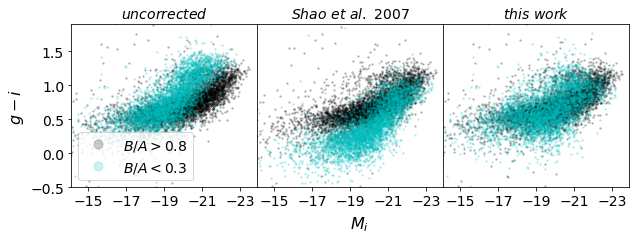

In [8]:
plt.figure(figsize=(10,3))
plt.subplots_adjust(wspace=.0)
# 
plt.subplot(1,3,1)
photflag = a100sdss['photFlag_gi'] == 1
colormag(a100sdss['absMag_i'][photflag], a100sdss['gmi_no_int'][photflag], 
         a100sdss['expAB_g'][photflag],'${uncorrected}$')
plt.ylabel('$g-i$',fontsize=16)
plt.legend(loc='lower left',markerscale=6)
#plt.gca()
plt.subplot(1,3,2)
photflag = a100sdss['photFlag_gi'] == 1
colormag(a100sdss['I_Shao'][photflag], a100sdss['gmi_Shao'][photflag],
         a100sdss['expAB_g'][photflag],'${Shao\ et\ al. \ 2007}$')
plt.yticks(())
ax = plt.gca()

plt.text(.5,-.25,'$M_i$',fontsize=16, transform = ax.transAxes)

plt.subplot(1,3,3)
photflag = a100sdss['photFlag_gi'] == 1
colormag(a100sdss['I_corrected'][photflag], a100sdss['gmi_corrected'][photflag],
         a100sdss['expAB_g'][photflag],'${this \ work}$')
plt.yticks(())

plt.savefig('Figure1.pdf')


## Figure 2: A100 vs NSA##

- data file = a100-nsa_overlapregion-mco.fits


**LEFT** 
- 2 panels
- left - everything is calculated based on NSA parameters
- red - matches
- blue - everything in NSA
- taylor stellar mass, but from magnitudes in NSA; could use stellar mass from K-correct
- compare taylor stellar mass from NSA magnitudes vs stellar mass from K-correct
- also compare color-mass diagram to see if it looks much different
- LogMstarTaylor_2 - based on NSA
- gmiShao is ok for y axis
- actually, calculate extinction like we do in the paper

- for log(a/b), use SERSIC_BA (compare with PETRO_BA90, we are using PETRO to measure the mag flux)
gamma_g = -0.35*Mg - 5.95, Mg < -17
extinction_g = gamma_g* log10(1./sersic_BA) 
- mag_corr = mag + extinction_g - NSA_EXTINCTION[3]

**RIGHT**
- red is galaxies that matched
- blue - a100 that didn't match to NSA
- using parameters from a100 catalog
- stellar mass taylor
- g-i color, corrected - gmi corrected - color to use on y axis - based on A100 values
- LogMstarTaylor_1
- use photFlag_gi = 1

- matchflag = 1, in a100 only
- matchflag = 2, in other catalog only
- matchflag = 3, matched in position, and then with a cut on velocity difference
- matchflag = 4, matched in position, but large velocity offset (ignore this set for now)


In [9]:
print('matchflag Ngal Ngal+photflag')
for i in range(1,5):
    #print('%i       %6i %6i'%(i,sum(a100nsa.matchFlag == i),(sum((a100nsa.photFlag_gi == 1) & (a100nsa.matchFlag == i)))))
    print('%i       %6i %6i'%(i,sum(a100nsa.matchFlag == i),(sum((photflagnsa == 1) & (a100nsa.matchFlag == i)))))

matchflag Ngal Ngal+photflag
1         1878    101
2        35965      0
3        13742   5292
4           27      8


In [10]:
a100flag = (a100nsa.photFlag_gi == 1) & (a100nsa.matchFlag == 1)
nsaflag =  (a100nsa.matchFlag == 2)
bothflag = (a100nsa.photFlag_gi == 1) & (a100nsa.matchFlag == 3)

###  Apply Internal and Galactic Extinction Corrections ###

In [11]:
# calculate extinction like we do in the paper
# - for log(a/b), use SERSIC_BA (compare with PETRO_BA90, we are using PETRO to measure the mag flux)

ba = a100nsa.expAB_r

gamma_g = np.zeros(len(a100nsa.ra_1))
# only apply correction for bright galaxies
mag_flag_g = a100nsa.absMag_g <= -17.
# equation from paper
gamma_g[mag_flag_g] = -0.35*a100nsa.absMag_g[mag_flag_g] - 5.95
extinction_g = gamma_g*np.log10(1./ba) 
# correct the absolute mag for internal AND galactic extinction
gmag_corr = a100nsa.modelMag_g + extinction_g - a100nsa.mw_extinction_g


gamma_i = np.zeros(len(a100nsa.ra_1))
mag_flag_i = a100nsa.absMag_i <= -17.
# equation from paper
gamma_i[mag_flag_i] = -0.15*a100nsa.absMag_i[mag_flag_i] - 2.55
extinction_i = gamma_g*np.log10(1./ba) 
# correct the absolute mag for internal AND galactic extinction
imag_corr = a100nsa.modelMag_i + extinction_i - a100nsa.mw_extinction_i

gmi_corr = gmag_corr - imag_corr

h = 0.7
logstellarmassTaylor=1.15+0.70*(gmi_corr) -0.4*(a100nsa.absMag_i+ 5.*np.log10(h))
# -0.68 + .7*gmi_cor + (Mi-4.56)/-2.5 

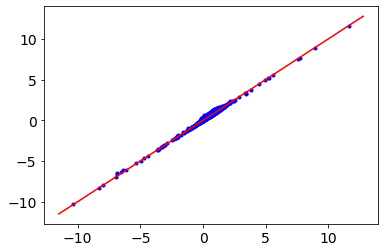

In [12]:
plt.figure()
plt.plot(a100nsa.gmi_corrected, gmi_corr,'b.')
xmin,xmax = plt.xlim()
xl=np.linspace(xmin,xmax,100)
plt.plot(xl,xl,'r-')

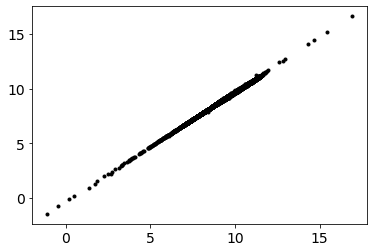

In [13]:
plt.figure()
plt.plot(logstellarmassTaylor, a100nsa.LogMstarTaylor_1,'k.')

### Calculate color correction for galaxies that are in NSA but not in AGC ###
Same as above but for galaxies in NSA only - need to use values from the NSA catalog

In [14]:
# calculate extinction like we do in the paper
# - for log(a/b), use SERSIC_BA (compare with PETRO_BA90, we are using PETRO to measure the mag flux)

ba = a100nsa.SERSIC_BA
Mg = a100nsa.SERSIC_ABSMAG[:,3]
Mi = a100nsa.SERSIC_ABSMAG[:,5]
mw_extinction_g = a100nsa.EXTINCTION[:,3]
mw_extinction_i = a100nsa.EXTINCTION[:,5]

gamma_g = np.zeros(len(a100nsa.ra_1))
# only apply correction for bright galaxies
mag_flag_g = Mg < -17.
# equation from paper
gamma_g[mag_flag_g] = -0.35*Mg[mag_flag_g] - 5.95
extinction_g = gamma_g*np.log10(1./ba) 
# correct the absolute mag for internal AND galactic extinction
gmag_corr = Mg + extinction_g - mw_extinction_g


gamma_i = np.zeros(len(a100nsa.ra_1))
mag_flag_i = Mi < -17.
# equation from paper
gamma_i[mag_flag_i] = -0.15*Mi[mag_flag_i] - 2.55
extinction_i = gamma_g*np.log10(1./ba) 
# correct the absolute mag for internal AND galactic extinction
imag_corr = Mi + extinction_i - mw_extinction_i

gmi_corr_nsa = gmag_corr - imag_corr

h = 0.7
logstellarmassTaylor_nsa=1.15+0.70*(gmi_corr_nsa) -0.4*(imag_corr+ 5.*np.log10(h))



### Compare B/A ###

We use 

Text(0.5, 0, 'SERSIC_BA')

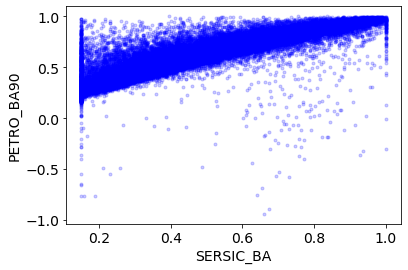

In [15]:
plt.plot(a100nsa.SERSIC_BA, a100nsa.PETRO_BA90,'b.', alpha=.2)
plt.ylabel('PETRO_BA90')
plt.xlabel('SERSIC_BA')

### Compare Taylor Stellar Mass ###

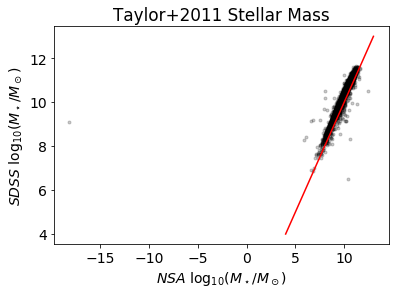

In [16]:
## compare NSA stellar mass to Taylor stellar mass 

plt.figure()
#plt.plot(a100nsa['LogMstarTaylor_2'][photflagnsa], np.log10(a100nsa['SERSIC_MASS'][photflagnsa]),'k.',alpha=0.2)
plt.plot(logstellarmassTaylor_nsa[photflagnsa], logstellarmassTaylor[photflagnsa],'k.',alpha=0.2)
plt.xlabel('$NSA \ \log_{10}(M_\star/M_\odot) $')
plt.ylabel('$SDSS \ \log_{10}(M_\star/M_\odot) $')
plt.title('Taylor+2011 Stellar Mass')
xl = np.linspace(4,13,100)
plt.plot(xl,xl,'r-')

# Figure 2 #

## left side  - A100-NSA match, plus NSA only ##

* plot (g-i) vs stellar mass for
  * galaxies that are in both catalogs (matchflag = 3)
  * galaxies that are in NSA only (matchflag = 2)
  
* In this plot, we are using 
  * NSA stellar mass: SERSIC_MASS
  * NSA SERSIC_ABSMAG[g] - NSA SERSIC_ABSMAG[i]

34631 34631
[ 10.          54.54545455  99.09090909 143.63636364 188.18181818
 232.72727273 277.27272727 321.81818182 366.36363636 410.90909091
 455.45454545 500.        ]


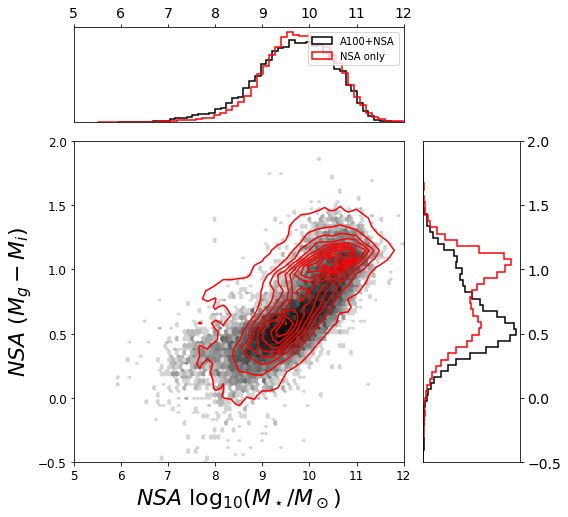

In [17]:
# correct to H0=70
x = np.log10(a100nsa.SERSIC_MASS/.7**2)
y = ((a100nsa.SERSIC_ABSMAG[:,3] - a100nsa.EXTINCTION[:,3]) - (a100nsa.SERSIC_ABSMAG[:,5] - a100nsa.EXTINCTION[:,5]))
nsa_mass_flag =  ( a100nsa.SERSIC_MASS > 1000.) 
# require phot error < 0.05 for abs mag
ivar = 1./.05**2
nsa_phot_flag = np.ones(len(nsa_mass_flag),'bool')
for i in np.arange(3,6):
    nsa_phot_flag = nsa_phot_flag & (a100nsa.SERSIC_AMIVAR[:,i] > (1./.05**2))
    
# flag1 = (a100nsa.matchFlag == 3) & (a100nsa.photFlag_gi == 1)
nsa_flag = nsa_mass_flag & nsa_phot_flag
flag1 = (a100nsa.matchFlag == 3) & nsa_flag #& photflagnsa  & (gmi_corr_nsa > -1) & (gmi_corr_nsa < 3.)#
# x1 = a100nsa.LogMstarTaylor_2[flag1]
x1 = x[flag1]
y1 = y[flag1]

flag2 = (a100nsa.matchFlag == 2)& nsa_flag #& (logstellarmassTaylor_nsa > 7) & (gmi_corr_nsa > -1) & (gmi_corr_nsa < 3.)#& (a100nsa.photFlag_gi == 1) 
x2 = x[flag2]
y2 = y[flag2]
print(len(x2), sum(flag2))
contour_levels = np.logspace(.7,5.5,15)
contour_levels = np.linspace(10,500,12)
print(contour_levels)
colormass(x1,y1, x2, y2, 'A100+NSA', 'NSA only', 'a100-nsa-color-mass-2.pdf', 
          hexbinflag=True,contourflag=True,contour_bins=40, ncontour_levels=contour_levels,
          xmin=5., ymin=-.5,xmax=12, 
         xlabel='$NSA \ \log_{10}(M_\star/M_\odot)$', ylabel='$ NSA \ (M_g - M_i)$', color2='r')

## Right Side of Figure 2 - A100-NSA match, plus A100 only##

* plot (g-i)_corrected vs Taylor stellar mass for
  * galaxies that are in both catalogs (matchflag = 3)
  * galaxies that are in A100 only (matchflag = 1)

1442 1442


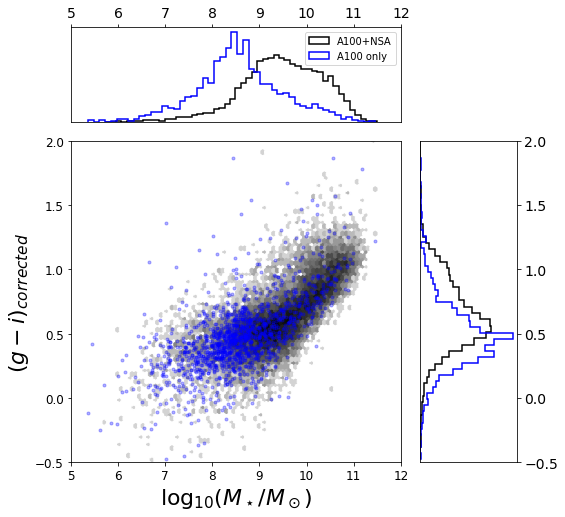

In [18]:
flag1 = (a100nsa.matchFlag == 3) & (a100nsa.photFlag_gi == 1)
# x1 = a100nsa.LogMstarTaylor_2[flag1]
x1 = a100nsa.LogMstarTaylor_1[flag1]
y1 = a100nsa.gmi_corrected[flag1]

flag2 = (a100nsa.matchFlag == 1) & (a100nsa.photFlag_gi == 1) 
x2 = a100nsa.LogMstarTaylor_1[flag2]
y2 = a100nsa.gmi_corrected[flag2]
print(len(x2), sum(flag2))
colormass(x1,y1, x2, y2, 'A100+NSA', 'A100 only', 'a100-nsa-color-mass-1.pdf', 
          hexbinflag=True, contourflag=False,color2='b',xmin=5., ymin=-.5,xmax=12)

# Figure 3: A100 vs S4G#

* catalog description - https://irsa.ipac.caltech.edu/data/SPITZER/S4G/gator_docs/s4g_colDescriptions.html
* datafile = a100-s4g_overlapregion-mco.fits
  * array is a100s4g
* stellar mass = mstar
* multiple magnitudes/colors available:

| Quantity | Variable |
|----------|----------|
|total I | it|
|total U-B  | ubt |
|total B-V | bvt |
|effective U-B color |  ube |
|effective B-V color | bve |
|total apparent corrected U-B color | ubtc|
|total apparent corrected B-V color | vbtc|
  
* galaxies that are in both catalogs (matchflag = 3)
* galaxies that are in A100 only (matchflag = 1)

### Missing Photometry

* The S4G catalog includes optical photometry from the literature, however, these data points are missing for a large fraction of galaxies in the sample
* Waiting to hear back from Mary to see if she can download catalog with the complete column list for S4G.
  * easiest way forward is to see if other columns in S4G has more data available.
  * for example, the catalog has I and B mags from Leda - more galaxies may have these available.
* tried downloading sdss data, but it looks like I got a lot of junk
* looked briefly at getting photometry from NED.  This should be possible if the full S4G catalog doesn't pan out.
* made a plot using the IRAC mags that are in the a100-s4g overlap catalog.  This works, but 3-4 micron does not track SF, which is really what we want.





In [133]:
print('total number in overlap region = ',len(a100s4g['matchFlag']))
print('number in common to both = ',sum(a100s4g['matchFlag']== 3))
print('number in A100 but not in S4G = ',sum(a100s4g['matchFlag']== 1))
print('number in S4G but not in A100 = ',sum(a100s4g['matchFlag']== 2))

total number in overlap region =  2311
number in common to both =  558
number in A100 but not in S4G =  1616
number in S4G but not in A100 =  137


In [174]:
# seems like this is mostly returning junk
# I'm guessing these galaxies will be hard b/c of shredding
def search_one_gal(pos):
    try:
        onegal = SDSS.query_region(pos,radius=6*u.arcsec,spectro=True, \
                            photoobj_fields=['objID','parentID','specObjID','ra','dec',\
                                    'u','g','r','i','z',
                                    'err_u','err_g','err_r','err_i','err_z',\
                                    'cmodelMag_u','cmodelMag_g','cmodelMag_r','cmodelMag_i','cmodelMag_z',\
                                    'cmodelMagErr_u','cmodelMagErr_g','cmodelMagErr_r','cmodelMagErr_i','cmodelMagErr_z',\
                                    'extinction_u','extinction_g','extinction_r','extinction_i','extinction_z','flags'])
    
 
        # select the closest object
        try: 
            if len(onegal) > 1:
                return onegal[0]
            else:
                return onegal
        except TypeError:
            print('problem with this galaxy')
            print(onegal)
            return [0]
    except ValueError:
        print('problem with this galaxy')
        #print(onegal)
        return [0]
    


In [175]:
# define sky coordinates for galaxies
pos1 = SkyCoord(a100s4g['ra_1']*u.deg,a100s4g['dec_1']*u.deg, frame='icrs')
pos2 = SkyCoord(a100s4g['ra_2']*u.deg,a100s4g['dec_2']*u.deg, frame='icrs')

In [179]:
onegal = search_one_gal(pos1[1])
print(onegal)

problem with this galaxy
None
[0]


In [180]:
onegal = search_one_gal(pos1[0])
fullsdss = Table(data=np.zeros(len(pos1),dtype=onegal.dtype))


In [181]:
for i,p in enumerate(pos1):
    #print(p)
    print('galaxy ',i)
    if np.isnan(p.ra.value):
        p = pos2[i]
    t = search_one_gal(p)
    #, len(t),len(fullsdss[i]))
    #print(t)
    #print(fullsdss[i])
    #if len(t) == len(fullsdss[i]):
    #print(t)
    try:
        fullsdss[i] = t
    except ValueError:
        continue

galaxy  0
galaxy  1
problem with this galaxy
None
galaxy  2
problem with this galaxy
None
galaxy  3
galaxy  4
galaxy  5
problem with this galaxy
None
galaxy  6
problem with this galaxy
None
galaxy  7
galaxy  8
galaxy  9
problem with this galaxy
None
galaxy  10
galaxy  11
galaxy  12
problem with this galaxy
None
galaxy  13
galaxy  14
problem with this galaxy
None
galaxy  15
galaxy  16
galaxy  17
galaxy  18
problem with this galaxy
None
galaxy  19
galaxy  20
galaxy  21
galaxy  22
problem with this galaxy
None
galaxy  23
galaxy  24
galaxy  25
problem with this galaxy
None
galaxy  26
galaxy  27
galaxy  28
galaxy  29
problem with this galaxy
None
galaxy  30
problem with this galaxy
None
galaxy  31
problem with this galaxy
None
galaxy  32
problem with this galaxy
None
galaxy  33
galaxy  34
galaxy  35
galaxy  36
problem with this galaxy
None
galaxy  37
galaxy  38
problem with this galaxy
None
galaxy  39
problem with this galaxy
None
galaxy  40
problem with this galaxy
None
galaxy  41
problem 

galaxy  362
galaxy  363
galaxy  364
galaxy  365
galaxy  366
galaxy  367
problem with this galaxy
None
galaxy  368
problem with this galaxy
None
galaxy  369
problem with this galaxy
None
galaxy  370
galaxy  371
problem with this galaxy
None
galaxy  372
galaxy  373
problem with this galaxy
None
galaxy  374
galaxy  375
problem with this galaxy
None
galaxy  376
problem with this galaxy
None
galaxy  377
galaxy  378
problem with this galaxy
None
galaxy  379
problem with this galaxy
None
galaxy  380
problem with this galaxy
None
galaxy  381
galaxy  382
galaxy  383
galaxy  384
galaxy  385
galaxy  386
galaxy  387
galaxy  388
galaxy  389
problem with this galaxy
None
galaxy  390
galaxy  391
problem with this galaxy
None
galaxy  392
galaxy  393
galaxy  394
problem with this galaxy
None
galaxy  395
problem with this galaxy
None
galaxy  396
galaxy  397
problem with this galaxy
None
galaxy  398
galaxy  399
problem with this galaxy
None
galaxy  400
galaxy  401
galaxy  402
galaxy  403
problem with thi

problem with this galaxy
None
galaxy  696
problem with this galaxy
None
galaxy  697
problem with this galaxy
None
galaxy  698
galaxy  699
problem with this galaxy
None
galaxy  700
problem with this galaxy
None
galaxy  701
problem with this galaxy
None
galaxy  702
galaxy  703
galaxy  704
galaxy  705
galaxy  706
problem with this galaxy
None
galaxy  707
galaxy  708
problem with this galaxy
None
galaxy  709
problem with this galaxy
None
galaxy  710
problem with this galaxy
None
galaxy  711
problem with this galaxy
None
galaxy  712
galaxy  713
galaxy  714
problem with this galaxy
None
galaxy  715
galaxy  716
galaxy  717
galaxy  718
galaxy  719
galaxy  720
galaxy  721
problem with this galaxy
None
galaxy  722
problem with this galaxy
None
galaxy  723
problem with this galaxy
None
galaxy  724
problem with this galaxy
None
galaxy  725
problem with this galaxy
None
galaxy  726
galaxy  727
galaxy  728
galaxy  729
galaxy  730
galaxy  731
galaxy  732
problem with this galaxy
None
galaxy  733
gala

galaxy  1054
galaxy  1055
problem with this galaxy
None
galaxy  1056
galaxy  1057
galaxy  1058
galaxy  1059
galaxy  1060
galaxy  1061
problem with this galaxy
None
galaxy  1062
galaxy  1063
galaxy  1064
galaxy  1065
galaxy  1066
problem with this galaxy
None
galaxy  1067
galaxy  1068
galaxy  1069
galaxy  1070
galaxy  1071
galaxy  1072
problem with this galaxy
None
galaxy  1073
galaxy  1074
problem with this galaxy
None
galaxy  1075
galaxy  1076
problem with this galaxy
None
galaxy  1077
galaxy  1078
galaxy  1079
galaxy  1080
galaxy  1081
problem with this galaxy
None
galaxy  1082
galaxy  1083
galaxy  1084
problem with this galaxy
None
galaxy  1085
galaxy  1086
galaxy  1087
problem with this galaxy
None
galaxy  1088
galaxy  1089
galaxy  1090
galaxy  1091
galaxy  1092
galaxy  1093
galaxy  1094
galaxy  1095
problem with this galaxy
None
galaxy  1096
galaxy  1097
galaxy  1098
galaxy  1099
problem with this galaxy
None
galaxy  1100
galaxy  1101
galaxy  1102
problem with this galaxy
None
gal

galaxy  1390
galaxy  1391
galaxy  1392
galaxy  1393
galaxy  1394
problem with this galaxy
None
galaxy  1395
problem with this galaxy
None
galaxy  1396
galaxy  1397
galaxy  1398
problem with this galaxy
None
galaxy  1399
problem with this galaxy
None
galaxy  1400
problem with this galaxy
None
galaxy  1401
galaxy  1402
problem with this galaxy
None
galaxy  1403
galaxy  1404
problem with this galaxy
None
galaxy  1405
galaxy  1406
problem with this galaxy
None
galaxy  1407
galaxy  1408
galaxy  1409
galaxy  1410
problem with this galaxy
None
galaxy  1411
galaxy  1412
problem with this galaxy
None
galaxy  1413
problem with this galaxy
None
galaxy  1414
galaxy  1415
problem with this galaxy
None
galaxy  1416
problem with this galaxy
None
galaxy  1417
problem with this galaxy
None
galaxy  1418
galaxy  1419
problem with this galaxy
None
galaxy  1420
galaxy  1421
problem with this galaxy
None
galaxy  1422
galaxy  1423
galaxy  1424
problem with this galaxy
None
galaxy  1425
galaxy  1426
galaxy  1

problem with this galaxy
None
galaxy  1706
problem with this galaxy
None
galaxy  1707
problem with this galaxy
None
galaxy  1708
galaxy  1709
problem with this galaxy
None
galaxy  1710
galaxy  1711
problem with this galaxy
None
galaxy  1712
problem with this galaxy
None
galaxy  1713
galaxy  1714
problem with this galaxy
None
galaxy  1715
galaxy  1716
problem with this galaxy
None
galaxy  1717
galaxy  1718
problem with this galaxy
None
galaxy  1719
problem with this galaxy
None
galaxy  1720
galaxy  1721
problem with this galaxy
None
galaxy  1722
problem with this galaxy
None
galaxy  1723
problem with this galaxy
None
galaxy  1724
galaxy  1725
galaxy  1726
galaxy  1727
problem with this galaxy
None
galaxy  1728
galaxy  1729
galaxy  1730
galaxy  1731
galaxy  1732
galaxy  1733
problem with this galaxy
None
galaxy  1734
problem with this galaxy
None
galaxy  1735
problem with this galaxy
None
galaxy  1736
problem with this galaxy
None
galaxy  1737
problem with this galaxy
None
galaxy  1738
p

galaxy  2010
problem with this galaxy
None
galaxy  2011
galaxy  2012
problem with this galaxy
None
galaxy  2013
galaxy  2014
problem with this galaxy
None
galaxy  2015
problem with this galaxy
None
galaxy  2016
galaxy  2017
galaxy  2018
problem with this galaxy
None
galaxy  2019
problem with this galaxy
None
galaxy  2020
problem with this galaxy
None
galaxy  2021
problem with this galaxy
None
galaxy  2022
galaxy  2023
problem with this galaxy
None
galaxy  2024
problem with this galaxy
None
galaxy  2025
problem with this galaxy
None
galaxy  2026
galaxy  2027
galaxy  2028
galaxy  2029
problem with this galaxy
None
galaxy  2030
galaxy  2031
galaxy  2032
problem with this galaxy
None
galaxy  2033
galaxy  2034
galaxy  2035
problem with this galaxy
None
galaxy  2036
problem with this galaxy
None
galaxy  2037
galaxy  2038
galaxy  2039
galaxy  2040
problem with this galaxy
None
galaxy  2041
galaxy  2042
galaxy  2043
galaxy  2044
problem with this galaxy
None
galaxy  2045
problem with this gala

galaxy  2299
problem with this galaxy
None
galaxy  2300
problem with this galaxy
None
galaxy  2301
galaxy  2302
galaxy  2303
problem with this galaxy
None
galaxy  2304
problem with this galaxy
None
galaxy  2305
problem with this galaxy
None
galaxy  2306
problem with this galaxy
None
galaxy  2307
problem with this galaxy
None
galaxy  2308
galaxy  2309
problem with this galaxy
None
galaxy  2310


In [182]:
fullsdss.write('tables/s4g-sdss.fits',format='fits',overwrite=True)

In [164]:
# plot sky positions of full catalog
nosdss = fullsdss['objID']== 0
print('number with no sdss match = ',sum(nosdss))

number with no sdss match =  19


Text(0.5, 1.0, 'My SDSS download vs MCO cat')

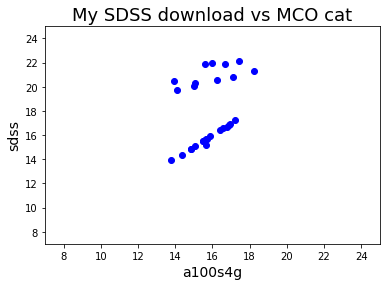

In [208]:
plt.figure()
plt.plot(a100s4g['modelMag_g'],fullsdss['g'],'bo')
plt.axis([7,25,7,25])
plt.xlabel('a100s4g',fontsize=14)
plt.ylabel('sdss',fontsize=14)
plt.title('My SDSS download vs MCO cat',fontsize=18)

## Trying NED search


In [183]:
from astroquery.ned import Ned

In [189]:
#result_table = Ned.query_region("NGC2894", radius=6 * u.arcsec)
phot_table = Ned.get_table('NGC2894', table='photometry', verbose=True)

In [185]:
print(result_table)

No. Object Name     RA     ... Redshift Points Diameter Points Associations
                 degrees   ...                                             
--- ----------- ---------- ... --------------- --------------- ------------
  1    NGC 2894    142.376 ...              12               7            0


In [194]:
print(phot_table['Observed Passband'])

 Observed Passband  
--------------------
      FUV (GALEX) AB
      FUV (GALEX) AB
      NUV (GALEX) AB
      NUV (GALEX) AB
             B (m_B)
           B (m_B^0)
                 m_p
   R (Johnson) (JKT)
H{alpha}+[NII] (JKT)
                   I
                 ...
   25 microns (IRAS)
   60 microns (IRAS)
  100 microns (IRAS)
            2380 MHz
     HI (21 cm line)
 HI (21cm) line WSRT
       HI 21 cm line
       HI 21 cm line
       HI 21 cm line
     HI (21 cm line)
     HI (21 cm line)
Length = 38 rows


number with both =  557
number with S4G only =  137
137 137
[  1.  10.  19.  28.  37.  46.  55.  64.  73.  82.  91. 100.]


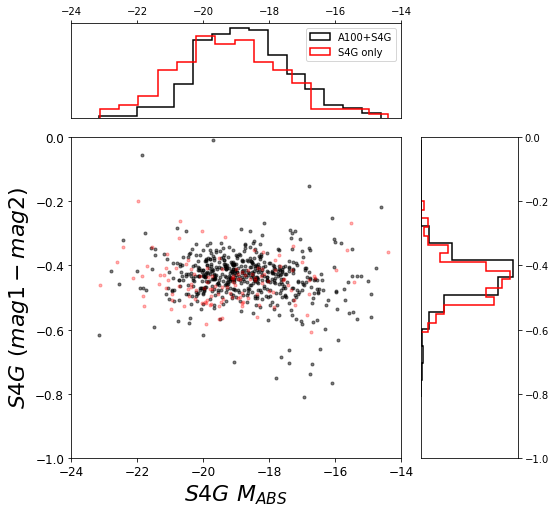

In [198]:
x = a100s4g.mstar
y = a100s4g.bvtc
x = a100s4g.mabs
y = fullsdss['g']-fullsdss['r']
y = a100s4g.mag1 - a100s4g.mag2
photflag = (fullsdss['err_g']< .05) & (fullsdss['err_r']< .05)& (fullsdss['err_i']< .05)
flag1 = (a100s4g.matchFlag == 3) & photflag
print('number with both = ',sum(flag1))
x1 = x[flag1]
y1 = y[flag1]

flag2 = (a100s4g.matchFlag == 2) & photflag
print('number with S4G only = ',sum(flag2))
x2 = x[flag2]
y2 = y[flag2]
print(len(x2), sum(flag2))
#contour_levels = np.logspace(.7,5.5,15)
contour_levels = np.linspace(1,100,12)
print(contour_levels)
colormass(x1,y1, x2, y2, 'A100+S4G', 'S4G only', 'a100-s4g-color-mass-1.pdf', 
          hexbinflag=False,contourflag=False,contour_bins=40, ncontour_levels=contour_levels,
          xmin=-24, ymin=-1,xmax=-14,ymax=0,nhistbin=15,alphagray=.5,
         xlabel='$S4G \ M_{ABS}$', ylabel='$ S4G \ (mag1 - mag2)$', color2='r')

[  1.  10.  19.  28.  37.  46.  55.  64.  73.  82.  91. 100.]


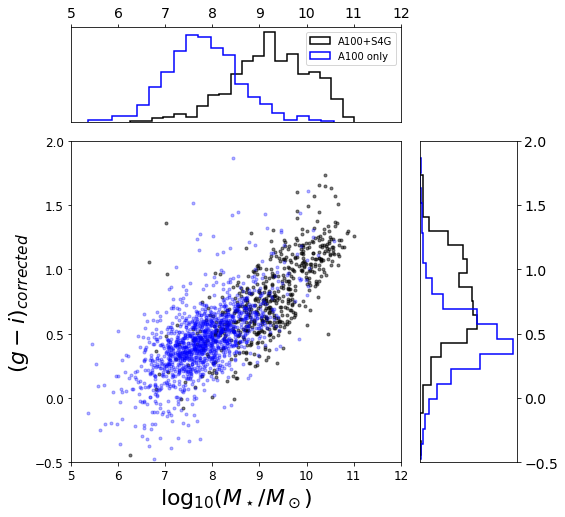

In [382]:
x = a100s4g.LogMstarTaylor
y = a100s4g.gmi_corrected

flag1 = (a100s4g.matchFlag == 3) & (a100s4g.photFlag_gi == 1)
# x1 = a100nsa.LogMstarTaylor_2[flag1]
x1 = x[flag1]
y1 = y[flag1]

flag2 = (a100s4g.matchFlag == 1)& (a100s4g.photFlag_gi == 1)
x2 = x[flag2]
y2 = y[flag2]
#print(len(x2), sum(flag2))
#contour_levels = np.logspace(.7,5.5,15)
contour_levels = np.linspace(1,100,12)
print(contour_levels)
colormass(x1,y1, x2, y2, 'A100+S4G', 'A100 only', 'a100-s4g-color-mass-2.pdf', 
          hexbinflag=False,contourflag=False,contour_bins=40, ncontour_levels=contour_levels,
          xmin=5., ymin=-.5,xmax=12,nhistbin=20,alphagray=.5,
          color2='b')

## Figure 4: A100 vs GSWL##

* need catalog from Adriana

## Figure 5: A100 vs Galaxy Zoo##

Galaxy Zoo 1
* data is available here https://data.galaxyzoo.org/
* targets all galaxies with spectroscopy in DR7?
* all they give is morphologies, so there isn't an easy way to compare populations.
* we could do a 1-sided comparison - matches in both catalogs, compared to A100 galaxies w/out matches
* but not easy to do galaxy zoo galaxies w/out A100 match unless we download SDSS photometry for them. 
    * catalog does include SDSS objID, so this wouldn't be too tough
    
* **need the a100 catalog** - for some reason I don't have this!
    

In [199]:
gz2 = fits.getdata('tables/gz2_hart16.fits.gz')

In [202]:
# select overlap region
overlapflag = (gz2.ra > 120) & (gz2.ra < 240) & (gz2.dec > 0) & (gz2.dec < 36)
gz2 = gz2[overlapflag]

In [203]:
gzpos = SkyCoord(gz2.ra*u.deg,gz2.dec*u.deg,frame='icrs')

In [205]:
# match to ALFALFA cat (using NSA here)
a100 = fits.getdata('tables/a100.code12.SDSSvalues190516.fits')

In [ ]:
aoverlapflag =  (a100.ra > 120) & (a100.ra < 240) & (a100.dec > 0) & (a100.dec < 36) & 

## Skyplot showing distribution of various surveys ##

http://learn.astropy.org/plot-catalog.html

* I want to make a figure that shows the sky coverage of the surveys that we are comparing

# Comparing Martha and Mary's Catalogs #

* Martha's A100 catalog has 31503 sources.
* Mary's catalog has 31502 sources.
* Mary's catalog has one fewer source.

Going to use Mary's catalog because it has the AGC columns appended already.

In [142]:
### OLD STUFF FROM WHEN I WAS MAKING MY OWN CUTS
# just overlap regions
'a100-nsa_overlapregion-mco.fits'
'a100-s4g_overlapregion-mco.fits'
agc_path = '/Users/rfinn/github/APPSS/tables/'


#a100
agc_name = agc_path+'a100.code12.SDSSvalues190516.csv'
agc_name = agc_path+'a100.code12.SDSSvalues190516.csv'
#agc_name = agc_path+'a100-SDSS-catalog-mco190725.fits'
mh_agc = ascii.read(agc_name)

#a100
#agc_name = agc_path+'a100.code12.SDSSvalues190516.csv'
agc_name = agc_path+'a100-SDSS-catalog-mco190725.fits'
agc = fits.getdata(agc_name,1)

# nsa
nsa_path = '/Users/rfinn/research/NSA/'
nsa_name = nsa_path+'nsa_v0_1_2.fits'
nsa = fits.getdata(nsa_name)
nsa_gi = nsa['ABSMAG'][:,3] - nsa['ABSMAG'][:,5]
h=.7
nsa_logstellarmassTaylor=1.15+0.70*(nsa['ABSMAG'][:,3]-nsa['ABSMAG'][:,5]) -0.4*(nsa['ABSMAG'][:,5]+ 5.*np.log10(h))

In [17]:
print(len(mh_agc),len(agc))

31503 31502


In [204]:
# define flag for keeping both samples
ramin = 120.
ramax = 240.
decmin = 0.
decmax = 36.
zmax = 0.05
ra = agc['ra']
dec = agc['dec']
redshift = agc['Vhelio']/c.c.value
keepagc = (ra > ramin) & (ra < ramax) & (dec > decmin) & (dec < decmax) & (redshift < .05) & (agc['modelMagErr_g'] < .01) & (agc['modelMagErr_i'] < .01)

# repeat for NSA
ra = nsa['RA']
dec = nsa['DEC']
redshift = nsa['ZDIST']

nsamagflag = (2.5*np.log10(np.sqrt(nsa['NMGY_IVAR'][:,3])) < .1) & (2.5*np.log10(np.sqrt(nsa['NMGY_IVAR'][:,5])) < .1)
nsamagflag = (nsa['NMGY'][:,3]/nsa['NMGY_IVAR'][:,3] > 20.) & (nsa['NMGY'][:,5]/nsa['NMGY_IVAR'][:,5] > 20.)
keepnsa = (ra > ramin) & (ra < ramax) & (dec > decmin) & (dec < decmax) & (redshift < .05) & nsamagflag & (nsa_gi > -1) & (nsa_gi < 2.5)



//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in true_divide
//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in 

### Plot g-i corrected vs stellar mass ###

In [ ]:
# from my original plot
# central panel
x1 = agc['LogMstarTaylor'][keepagc]
y1 = agc['gmi_corrected'][keepagc]
x2 = nsa_logstellarmassTaylor[keepnsa]
y2 = nsa_gi[keepnsa]
colormass(x1,y1,x2,y2,'colormass-myversion.png')

Text(336.971,0.5,'$(g-i)_{corrected} $')

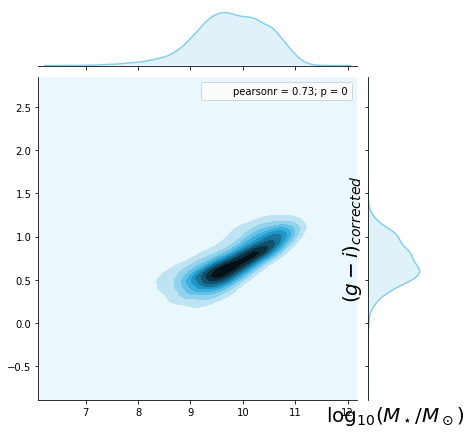

In [217]:
sns.jointplot(x=agc['LogMstarTaylor'][keepagc], y=agc['gmi_corrected'][keepagc], kind='kde', color="skyblue")
plt.xlabel('$\log_{10}(M_\star/M_\odot) $',fontsize=20)
plt.ylabel('$(g-i)_{corrected} $',fontsize=20)